In [2]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# Read in CSV files
brands = pd.read_csv('Datasets/brands.csv')
categories = pd.read_csv('Datasets/categories.csv')
customers = pd.read_csv('Datasets/customers.csv')
order_items = pd.read_csv('Datasets/order_items.csv')
orders = pd.read_csv('Datasets/orders.csv')
products = pd.read_csv('Datasets/products.csv')
staffs = pd.read_csv('Datasets/staffs.csv')
stocks = pd.read_csv('Datasets/stocks.csv')
stores = pd.read_csv('Datasets/stores.csv')

# Create database connection
connection = sqlite3.connect('bike_store.db')

# Insert data into database
brands.to_sql('brands', connection, if_exists='replace', index=False)
categories.to_sql('categories', connection, if_exists='replace', index=False)
customers.to_sql('customers', connection, if_exists='replace', index=False)
order_items.to_sql('order_items', connection, if_exists='replace', index=False)
orders.to_sql('orders', connection, if_exists='replace', index=False)
products.to_sql('products', connection, if_exists='replace', index=False)
staffs.to_sql('staffs', connection, if_exists='replace', index=False)
stocks.to_sql('stocks', connection, if_exists='replace', index=False)
stores.to_sql('stores', connection, if_exists='replace', index=False)


3

In [16]:
query = """
WITH customer_stats AS (
    SELECT
        customer_id,
        SUM(quantity * list_price * (1 - discount)) AS total_spent,
        COUNT(DISTINCT orders.order_id) AS total_orders,
        julianday('2018-12-29') - julianday(MAX(order_date)) AS days_since_last_purchase
    FROM
        orders
    INNER JOIN
        order_items
    ON
        orders.order_id = order_items.order_id
    GROUP BY
        customer_id
)

SELECT
    customer_id,
    CASE WHEN total_orders > customer_id THEN 'repeat buyer'
         ELSE 'one-time buyer'
         END AS purchase_frequency,
    CASE WHEN days_since_last_purchase < 90 THEN 'recent buyer'
         ELSE 'not recent buyer'
         END AS purchase_recency,
    CASE WHEN total_spent/(SELECT MAX(total_spent) FROM customer_stats) >= .65 THEN 'big spender'
         WHEN total_spent/(SELECT MAX(total_spent) FROM customer_stats) <= .30 THEN 'low spender'
         ELSE 'average spender' 
         END AS buying_power
FROM
    customer_stats
"""

df = pd.read_sql_query(query, connection)
df


,customer_id,purchase_frequency,purchase_recency,buying_power
0,1,repeat buyer,recent buyer,big spender
1,2,repeat buyer,not recent buyer,average spender
2,3,one-time buyer,recent buyer,big spender
3,4,one-time buyer,not recent buyer,average spender
4,5,one-time buyer,not recent buyer,average spender
...,...,...,...,...
1440,1441,one-time buyer,not recent buyer,low spender
1441,1442,one-time buyer,not recent buyer,low spender
1442,1443,one-time buyer,not recent buyer,low spender
1443,1444,one-time buyer,not recent buyer,low spender


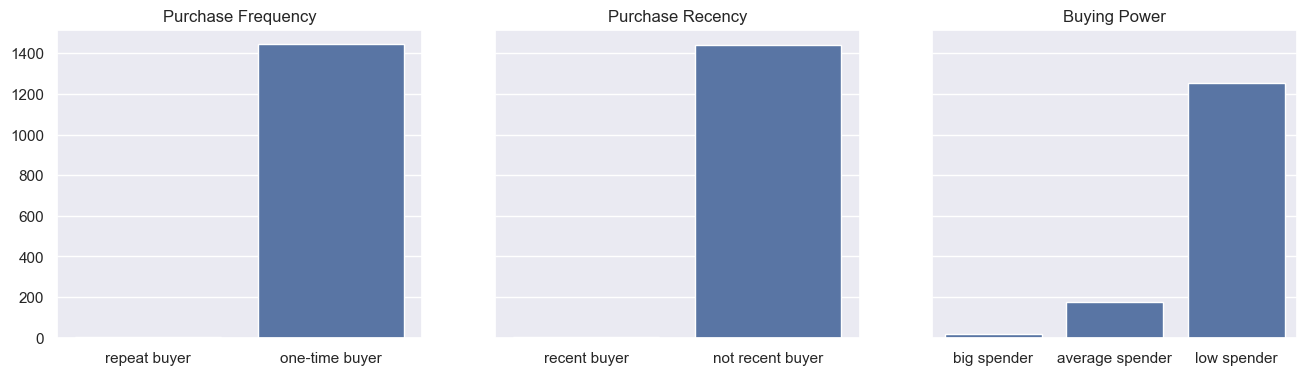

In [17]:
fig, ax = plt.subplots(ncols=3, figsize=(16, 4), sharey=True)
sns.countplot(data=df, x='purchase_frequency', ax=ax[0])
sns.countplot(data=df, x='purchase_recency', ax=ax[1])
sns.countplot(data=df, x='buying_power', ax=ax[2])
ax[0].set_title('Purchase Frequency')
ax[1].set_title('Purchase Recency')
ax[2].set_title('Buying Power')
for axis in ax:
    axis.set_ylabel('')
    axis.set_xlabel('')
plt.savefig("Customer segmentation")

In [18]:
query = """
WITH product_categories AS (
    SELECT
        product_id,
        category_name
    FROM
        products
    INNER JOIN
        categories
    ON
        products.category_id = categories.category_id
),

product_sales_ym AS (
    SELECT
        strftime('%Y', order_date) AS year,
        strftime('%m', order_date) AS month,
        product_id,
        SUM(quantity) AS units_sold
    FROM
        orders
    INNER JOIN
        order_items
    ON
        orders.order_id = order_items.order_id
    GROUP BY
        year,month,product_id
)

SELECT
    month,
    category_name,
    AVG(units_sold) AS avg_units_sold
FROM
    product_sales_ym
INNER JOIN
    product_categories
ON
    product_sales_ym.product_id = product_categories.product_id
GROUP BY
    month,category_name;
"""

df = pd.read_sql_query(query, connection)
df

,month,category_name,avg_units_sold
0,01,Children Bicycles,2.973684
1,01,Comfort Bicycles,2.846154
2,01,Cruisers Bicycles,3.000000
3,01,Cyclocross Bicycles,3.200000
4,01,Electric Bikes,2.733333
...,...,...,...
79,12,Cruisers Bicycles,4.965517
80,12,Cyclocross Bicycles,8.600000
81,12,Electric Bikes,5.750000
82,12,Mountain Bikes,3.461538


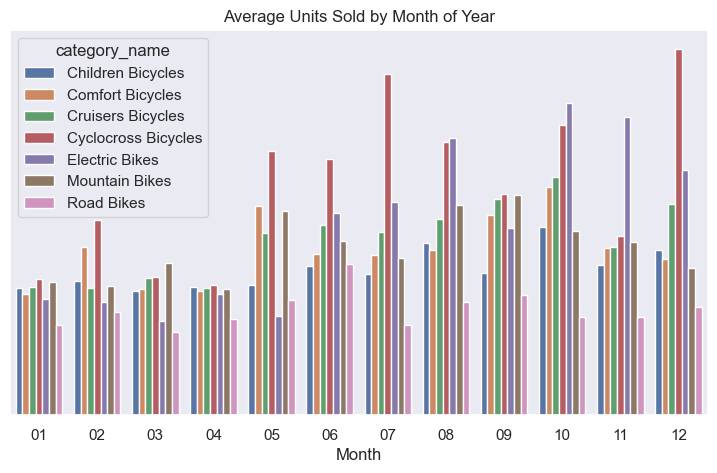

In [19]:
fig, ax = plt.subplots(figsize=(9,5))
sns.barplot(data=df, x='month', y='avg_units_sold', hue='category_name', errorbar=None, ax=ax)
ax.set_yticks([])
ax.set_ylabel('')
ax.set_xlabel('Month')
ax.set_title('Average Units Sold by Month of Year')
plt.savefig("Average Units Sold by Month of Year")

In [20]:
query = """
SELECT
    c.first_name || ' ' || c.last_name AS customer_name,
    COUNT(s.order_id) AS total_transactions,
    RANK() OVER (ORDER BY COUNT(s.order_id) DESC) AS rank
FROM
    orders s
INNER JOIN
    customers c 
ON 
    s.customer_id = c.customer_id
GROUP BY
    customer_name
ORDER BY
    total_transactions DESC;
"""

df = pd.read_sql_query(query, connection)
df

,customer_name,total_transactions,rank
0,Williemae Holloway,3,1
1,Tobie Little,3,1
2,Tameka Fisher,3,1
3,Saturnina Garner,3,1
4,Ronna Butler,3,1
...,...,...,...
1439,Adam Thornton,1,133
1440,Adam Henderson,1,133
1441,Abram Copeland,1,133
1442,Abbey Pugh,1,133


In [21]:
query = """
SELECT
    product_a,
    product_b,
    co_purchase_count
FROM 
    (
     SELECT
         p1.product_name AS product_a,
         p2.product_name AS product_b,
         COUNT(*) AS co_purchase_count
     FROM
         order_items s1
     INNER JOIN
         order_items s2 ON s1.order_id = s2.order_id AND s1.product_id <> s2.product_id
     INNER JOIN
         products p1 ON s1.product_id = p1.product_id
     INNER JOIN
         products p2 ON s2.product_id = p2.product_id
     GROUP BY
         p1.product_id, p2.product_id
    ) subquery
ORDER BY
    co_purchase_count DESC;
"""

df = pd.read_sql_query(query, connection)
df

,product_a,product_b,co_purchase_count
0,Heller Shagamaw Frame - 2016,Electra Girl's Hawaii 1 (16-inch) - 2015/2016,15
1,Electra Girl's Hawaii 1 (16-inch) - 2015/2016,Heller Shagamaw Frame - 2016,15
2,Trek Conduit+ - 2016,Surly Straggler 650b - 2016,14
3,Surly Straggler 650b - 2016,Trek Conduit+ - 2016,14
4,Electra Townie Original 21D - 2016,Electra Cruiser 1 (24-Inch) - 2016,14
...,...,...,...
6923,Electra Townie Original 21D EQ Ladies' - 2018,Trek X-Caliber Frameset - 2018,1
6924,Electra Townie Original 21D Ladies' - 2018,Trek Girl's Kickster - 2017,1
6925,Electra Townie Original 21D Ladies' - 2018,Trek Domane SL 8 Disc - 2018,1
6926,Electra Townie Original 21D Ladies' - 2018,Trek Conduit+ - 2018,1


In [22]:
query = """
SELECT
    customer_id,
    AVG(julianday(order_date) - julianday(prev_order_date)) AS avg_days_between_purchases
FROM 
    (
     SELECT
         c.customer_id,
         order_date,
         LAG(order_date) OVER (PARTITION BY c.customer_id ORDER BY order_date) AS prev_order_date
     FROM
         orders o
    INNER JOIN
         customers c ON o.customer_id = c.customer_id
    ) subquery
WHERE 
    prev_order_date IS NOT NULL
GROUP BY
    customer_id
ORDER BY avg_days_between_purchases ASC;
"""

df = pd.read_sql_query(query, connection)
df

,customer_id,avg_days_between_purchases
0,35,2.0
1,117,7.0
2,109,56.0
3,63,66.0
4,92,70.0
...,...,...
126,80,821.0
127,57,822.0
128,175,829.0
129,91,832.0
